In [134]:
import pandas as pd
import numpy as np
import re
import os
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [10]:
# names of the experiments for naming of the files
experiment_list = ["E007", "E008", "E011"]

# list of the names of the excel files with the raw data of the experiments
file_name_list = ["..\\data\\" + i for i in os.listdir("..\\data") if i.endswith(".xlsx")]
file_name_list

['..\\data\\39_20230710_Kai_mutants.xlsx',
 '..\\data\\40_20230717_Kai_mutants_and_friends.xlsx',
 '..\\data\\43_20230731_Kai_mutants_and_friends.xlsx']

In [3]:
# conversion factor from inches to cm for the size of the plots
cm_in_inches = 2.54

In [136]:
# dictionary with the colors associated with the strains contained in the experiments
color_dic = {r"WT": "forestgreen",
             r"KaiA3": "brown",
             r"KaiB3": "crimson",
             r"KaiC3": "darkorange",
             r"KaiA3B3": "olive",
             r"KaiA3C3": "lawngreen",
             r"KaiB3C3": "mediumturquoise",
             r"KaiA3B3C3": "dodgerblue",
             r"KaiA1B1C1": "orchid"}

In [111]:
def renaming_of_raw_data(file_name_list:list, experiments:list, save=False) -> None:

    """
    This function reads in the raw data as a pandas DataFrame and renames the
    columns based on the names given to each well in the BioLection software.
    The data is then trimmed to the first 84 h and unnecessary strains are removed
    and the result is saved to a csv file.
    """

    for file, experiment in zip(file_name_list, experiments):
        # raw data is saved in sheet 4 of the excel file
        raw_data = pd.read_excel(file, sheet_name=3, skiprows=range(1,4))
        keys = raw_data.keys()[2:]
        keys_dict = {i: re.sub(r"Ch\d_", r"", j) for i, j in zip(keys, keys)}
        raw_data = raw_data.rename(columns=keys_dict)
        raw_data = raw_data[[i for i in raw_data.keys() if i.startswith("raw") or i.startswith("Time[h]")]]


        my_names = [i.replace("raw_", "") for i in raw_data.keys()]
        # the names are saved in sheet 2 of the excel file
        names = pd.read_excel(file, sheet_name=1, skiprows=range(1,4))
        names = names.query("Well == @my_names")
        names_dict = {"raw_" + i: j.replace(",", "").replace(" ", "_").replace("Uppsala_", "") for i, j in zip(names["Well"], names["Description"])}
        raw_data = raw_data.rename(columns=names_dict)

        # trimming the data to the first 84 h
        index_end = raw_data[raw_data["Time[h]"] <= 84].shape[0] + 1 
        raw_data = raw_data.iloc[:index_end,]   

        # trimming strains that are not needed:
        raw_data = raw_data[[key for key in raw_data.keys() if not re.search(r"7942|glgC|mVenus|Wilde", key)]]

        # saving the result to a csv file:
        if save:
            raw_data.to_csv(f"..\\data\\{experiment}_renamed_data.csv")

In [112]:
renaming_of_raw_data(file_name_list, experiment_list, save=True)

In [113]:
def identify_unique_keys(experiment_list:list) -> dict:

    """
    Function for identifying the unique part of the names of the DataFrame
    and saving them in a dictionary sorted by the experiments.
    """

    experiments_2_key_2_names = {}
    for experiment in experiment_list:
        data = pd.read_csv(f"..\\data\\{experiment}_renamed_data.csv", index_col=0)
        unique_keys = {}
        for i in data.keys()[1:]:
            unique_part = "_".join(i.split("_")[0:2])
            if unique_part not in unique_keys:
                unique_keys[unique_part] = []
            unique_keys[unique_part].append(i)

        experiments_2_key_2_names[experiment] = unique_keys
    return experiments_2_key_2_names

In [149]:
experiment_keys = identify_unique_keys(experiment_list=experiment_list)

In [115]:
def polynomial_regression(y:pd.Series, kernel:np.array, poly=4) -> (np.array, np.array, np.array):

    """
    Take a pd.Series from the raw data and fit a polynomial regression of the 4th degree to it.
    The smoothed signal, signal and polynomial regression are returned.
    """
    # 4th degree polynomial regression
    y_reg = np.array(np.arange(len(y))).reshape(-1,1)
    pf = PolynomialFeatures(poly)
    y_reg = pf.fit_transform(y_reg)
    reg_fit = LinearRegression().fit(y_reg, y)
    reg_predict = reg_fit.predict(y_reg)

    # the polynomial regression is subtracted from the raw data
    signal = y - reg_predict
    # from the result, the mean is subtracted
    signal -= signal.mean()
    #the signal is smoothened by a rolling average with the kernel size given to the function
    smoothed_signal = np.convolve(signal, kernel, mode='same')
    return smoothed_signal, signal, reg_predict

In [116]:
def avg_first_data(experiment_list:list, experiment_keys_keys:dict) -> None:

    """
    Function for calculating the average of all replicates of one experiment
    and performing the regression analysis on it afterwards.
    The results are saved to a csv file.
    """

    for experiment in experiment_list:

        # reading in the trimmed and renamed data
        raw_data = pd.read_csv(f"..\\data\\{experiment}_renamed_data.csv", index_col=0)
        unique_keys = experiment_keys[experiment]

        data = pd.DataFrame()

        data["Time(h)"] = raw_data["Time[h]"]

        kernel_size = 40
        kernel = np.ones(kernel_size) / kernel_size

        # the first three hours are cut off to eliminate measuring artifacts
        index_1 = data["Time(h)"][data["Time(h)"] >= 3].index[0]

        for key in unique_keys:
            keys = unique_keys[key]
            sub_data = raw_data[keys]

            for i in sub_data.keys():
                data[i] = sub_data[i]

            mean = np.mean(sub_data, axis=1)
            std = np.std(sub_data, axis=1)

            mean_name = key + "_mean"
            sd_name = key + "_sd"
            reg_name = key + "_reg"
            sig_name = key + "_signal"
            smooth_name = key + "_smoothed"

            data[mean_name] = mean
            data[sd_name] = std

            # regression analysis
            smoothed_signal, signal, reg_predict = polynomial_regression(data[mean_name][index_1:], kernel)

            nan_arr = np.array([np.nan for i in range(0, data.shape[0] - smoothed_signal.shape[0])])
            smoothed_signal = pd.DataFrame(np.concatenate([nan_arr, smoothed_signal], axis=0), columns=[smooth_name])
            signal = pd.DataFrame(np.concatenate([nan_arr, signal], axis=0), columns=[sig_name])
            reg_predict = pd.DataFrame(np.concatenate([nan_arr, reg_predict], axis=0), columns=[reg_name])

            data = pd.concat([data, reg_predict, signal, smoothed_signal], axis=1, ignore_index=False)
        data.to_csv(f"..\\data\\{experiment}_total_data_mean_first.csv")

In [117]:
avg_first_data(experiment_list, experiment_keys)

In [118]:
def avg_last_data(experiment_list:list, experiment_keys_keys:dict) -> None:

    """
    Function for performing the regression analysis for each replicate first
    and then taking the average of the resulting smoothed signal.
    The results are saved to a csv file.
    """

    for experiment in experiment_list:
        
        # reading in the trimmed data set
        raw_data = pd.read_csv(f"..\\data\\{experiment}_renamed_data.csv", index_col=0)
        unique_keys = experiment_keys[experiment]

        data = pd.DataFrame()

        data["Time(h)"] = raw_data["Time[h]"]

        kernel_size = 40
        kernel = np.ones(kernel_size) / kernel_size
        
        # the first three hours are cut off to eliminate measuring artifacts
        index_1 = data["Time(h)"][data["Time(h)"] >= 3].index[0]

        cutoff = data.shape[0] - data[index_1:].shape[0]

        for key in unique_keys:
            keys = unique_keys[key]
            sub_data = raw_data[keys]

            for i in sub_data.keys():
                data[i] = sub_data[i]

                reg_name = i + "_reg"
                sig_name = i + "_signal"
                smooth_name = i + "_smoothed"

                smoothed_signal, signal, reg_predict = polynomial_regression(data[i][index_1:], kernel)

                nan_arr = np.array([np.nan for i in range(0, cutoff)])
                smoothed_signal = pd.DataFrame(np.concatenate([nan_arr, smoothed_signal], axis=0), columns=[smooth_name])
                signal = pd.DataFrame(np.concatenate([nan_arr, signal], axis=0), columns=[sig_name])
                reg_predict = pd.DataFrame(np.concatenate([nan_arr, reg_predict], axis=0), columns=[reg_name])
                data = pd.concat([data, reg_predict, signal, smoothed_signal], axis=1, ignore_index=False)

            smoothed_data = data[[j for j in data.keys() if re.search(r"smoothed", j) and re.search(key + "_", j)]][cutoff:]

            mean_name = key + "_mean"
            sd_name = key + "_sd"

            mean = np.mean(smoothed_data, axis=1)
            std = np.std(smoothed_data, axis=1)

            mean = pd.DataFrame(np.concatenate([nan_arr, mean], axis=0), columns=[mean_name])
            std = pd.DataFrame(np.concatenate([nan_arr, std], axis=0), columns=[sd_name])

            data[mean_name] = mean
            data[sd_name] = std

        data.to_csv(f"..\\data\\{experiment}_total_data_mean_after.csv")

In [119]:
avg_last_data(experiment_list, experiment_keys)

In [120]:
def peak_timepoint_csv(experiment_list:list) -> None:

    """
    Function for identifying the peaks in the smoothed signal.
    The timepoints and heights of the peaks for each strain are saved to a csv file.
    """

    for experiment in experiment_list:
        data = pd.read_csv(f"..\\data\\{experiment}_total_data_mean_after.csv", index_col=0)
        sub_data = data[[key for key in data.keys() if re.search(r"rep\d_smoothed|Time", key)]]
        peaks_df = pd.DataFrame()
        for key in sub_data.iloc[:,1:]:
            mean = np.mean(sub_data[key])
            maximum = np.max(sub_data[key])

            # identifying of the peaks:
            #peaks need to be separated by 150 indices, have a width of at least 65 indices and a height of at least the mean + 20 % of the highest value
            peaks = find_peaks(sub_data[key], distance=150, width=65, height=mean+0.2*maximum) # 150 <=> 12.5 h; 65 <=> 5.42 h
            peaks = peaks[0]
            peak_timepoints = np.array([])
            peak_heights = np.array([])
            name = "{}_{}_{}".format(key.split("_")[0], key.split("_")[1], key.split("_")[2])
            for peak in peaks:
                # only peaks after 12 h are considered
                if sub_data["Time(h)"][peak] >= 12:
                    peak_timepoints = np.append(peak_timepoints, np.array(sub_data["Time(h)"][peak]))
                    peak_heights = np.append(peak_heights, np.array(sub_data[key][peak]))
                else:
                    continue
            # arrays with less than 3 peak timepoints/heights are filled with np.nan so that the results can be put into a DataFrame            
            if peak_timepoints.shape[0] < 3:
                for i in range(0, 3 - peak_timepoints.shape[0]):
                    peak_timepoints = np.append(peak_timepoints, np.nan)
                    peak_heights = np.append(peak_heights, np.nan)
            peaks_df[name + "_peak_timepoints_(h)"] = peak_timepoints
            peaks_df[name + "_peak_heights_(a.u.)"] = peak_heights
        peaks_df.to_csv(f"..\\data\\{experiment}_peaks_and_timepoints.csv")

In [121]:
peak_timepoint_csv(experiment_list)

In [144]:
def peaks_stats_single_experiment(experiment_list:list, experiment_keys:dict) -> None:

    """
    Function to perform normalization of the peak data to make them comparable between experiments.
    The ratio of the height and the phase shift of the first peak compared to the WT are calculated.
    The results are stored in a DataFrame and saved to a csv file.
    """
    for experiment in experiment_list:
        # reading in the data for peak height and timepoints
        peaks_df = pd.read_csv(f"..\\data\\{experiment}_peaks_and_timepoints.csv", index_col=0)
        unique_keys = experiment_keys[experiment]

        # DataFrame to store the calculated values in
        mean_peaks = pd.DataFrame()

        for key in unique_keys:
            # sorting for the individual strains
            sub_data = peaks_df[[i for i in peaks_df.keys() if re.search(key + r"_", i)]]

            # only the timepoints
            timepoints = sub_data[[i for i in sub_data.keys() if re.search(r"timepoints", i)]]

            # number of replicates
            n = len(timepoints.iloc[0,:])

            # calculating the mean timepoint for only the first peak
            mean_tp = np.mean(timepoints.iloc[0,:])
            # calculating the standard deviation of the timepoint of the first peak
            sd_tp = np.std(timepoints.iloc[0,:])

            # only the heights of the peaks
            heights = sub_data[[i for i in sub_data.keys() if re.search(r"heights", i)]]

            # calculating the mean height for only the first peak
            mean_h = np.mean(heights.iloc[0,:])
            # calculating the standard deviation of the height of the first peak
            sd_h = np.std(heights.iloc[0,:])

            # storing the values of the WT in variables for comparison
            if re.search(r"6803_WT", key):
                WT_mean_tp = mean_tp
                WT_sd_tp = sd_tp
                WT_mean_h = mean_h
                WT_sd_h = sd_h
            
            # height ratio of each strain compared to the WT
            h_ratio = mean_h / WT_mean_h
            # error for the height ratio
            ratio_error = sd_h / mean_h  + WT_sd_h / WT_mean_h
            # difference in timpoint of the first peak of each strain compared to the WT (phase shift)
            tp_difference = mean_tp - WT_mean_tp
            # error of the phase shift
            difference_error = sd_tp + WT_sd_tp

            value_list = [mean_tp, sd_tp, mean_h, sd_h, tp_difference, difference_error, h_ratio, ratio_error]

            # adding each value to a DataFrame
            mean_peaks[key + f"_n={n}"] = value_list

        # renaming the rows of the DataFrame
        mean_peaks = mean_peaks.rename(index={0: "mean_timepoint",
                        1: "sd_timepoint",
                        2: "mean_height",
                        3: "sd_height",
                        4: "difference_timepoint_to_WT",
                        5: "difference_error",
                        6: "ratio_height_to_WT",
                        7: "ratio_error"})
                        
        # saving to csv
        mean_peaks.to_csv(f"..\\data\\{experiment}_peak_stats.csv")

In [145]:
peaks_stats_single_experiment(experiment_list, experiment_keys)

In [138]:
width = 21
height = 27.6
dimensions = (width/cm_in_inches, height/cm_in_inches)
lw = 2

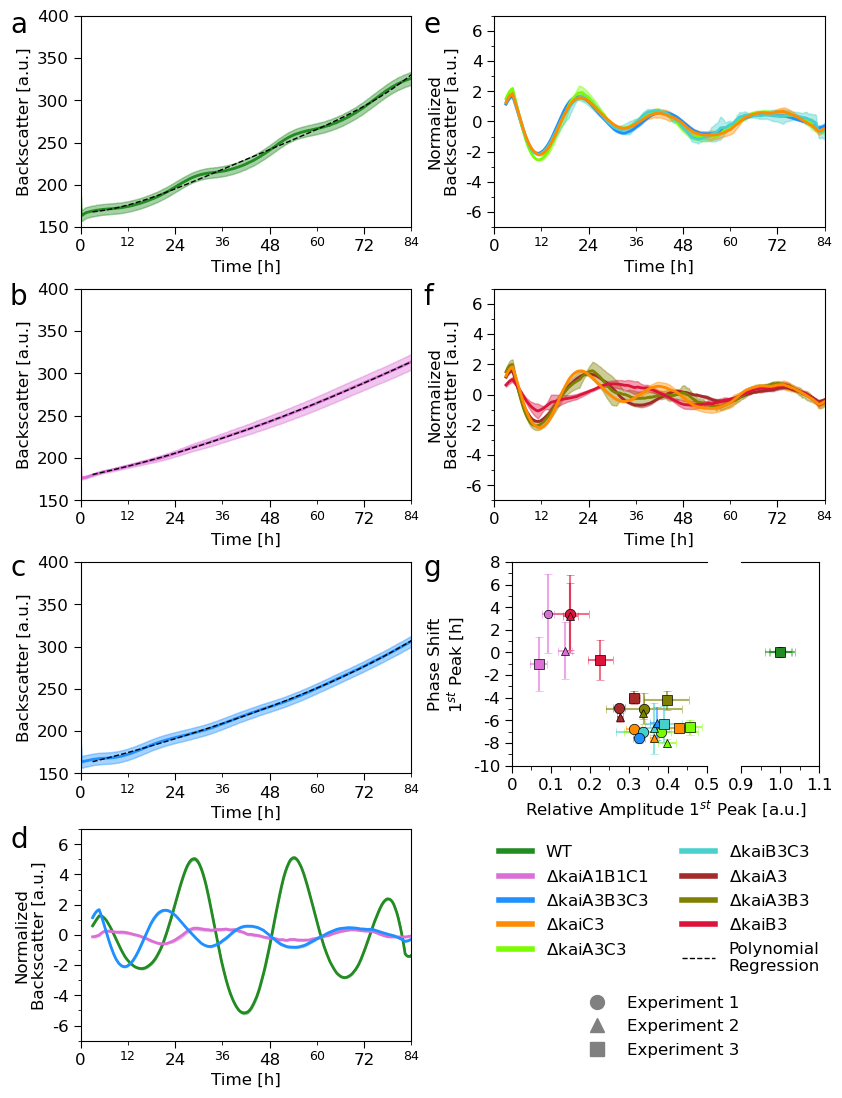

In [147]:
def multiplot_4x2(color_dic:dict) -> None:

    """
    Function for plotting the data from the first experiment and the normalized data from all three experiments to a
    4x2 subplot.
    """
    
    E007_data_avg_last = pd.read_csv("..\\data\\E007_total_data_mean_after.csv", index_col=0)
    E007_data_avg_first = pd.read_csv("..\\data\\E007_total_data_mean_first.csv", index_col=0)


    E007 = pd.read_csv("..\\data\\E007_peak_stats.csv", index_col=0)
    E008 = pd.read_csv("..\\data\\E008_peak_stats.csv", index_col=0)
    E011 = pd.read_csv("..\\data\\E011_peak_stats.csv", index_col=0)
    data_list = [E007, E008, E011]

    search_keys = ["6803_WT", "6803_deltaKaiA1B1C1", "6803_deltaKaiA3B3C3", r"A1B1C1|A3B3C3|WT",  r"C3_", r"A3B3_|A3_|KaiC3_|B3_"]

    fig = plt.figure(figsize=dimensions, layout="constrained") # , layout="constrained"


    gs1 = GridSpec(4, 2, figure=fig)
    gs2 = gs1[2, 1].subgridspec(1, 7)
    ax1 = fig.add_subplot(gs1[0,0])
    ax2 = fig.add_subplot(gs1[1,0])
    ax3 = fig.add_subplot(gs1[2,0])
    ax4 = fig.add_subplot(gs1[3,0])
    ax5 = fig.add_subplot(gs1[0,1])
    ax6 = fig.add_subplot(gs1[1,1])  

    ax7 = fig.add_subplot(gs2[0, 0:5]) 
    ax8 = fig.add_subplot(gs2[0,5:7])

    ax9 = fig.add_subplot(gs1[3,1])

    xticks_major = [i for i in range(0, 85, 24)]
    xticks_minor = [i for i in range(0, 85, 12)]

    def plot_growth_with_sd(data:pd.DataFrame, ax:plt.axis, search_key:str) -> None:
        sub_data = data[[i for i in data.keys() if re.search(search_key, i)]]

        x = data["Time(h)"]
        y1 = sub_data[f"{search_key}_mean"]
        sd1 = sub_data[f"{search_key}_sd"]
        y2 = sub_data[f"{search_key}_reg"]

        for key in color_dic:
            if re.search(key, search_key):
                color = color_dic[key]

        name = search_key.removeprefix("6803_").removesuffix("_mean").replace("delta", "\u0394").replace("_", " ").replace("K", "k")

        n = data[[i for i in data.keys() if re.search(search_key + r"_rep\d", i)]].shape[1]

        ax.plot(x, y1, color=color, lw=lw, label=f"{name} \u00B1 sd; n = {n}")
        ax.fill_between(x, y1+sd1, y1-sd1, color=color, alpha=0.4)
        ax.plot(x, y2, color="k", alpha=1, lw=1, ls="--", label="Polynomial Regression")

        ax.set_xlim(0, max(x))

        ax.set_ylim(150, 400)

        

        ax.set_xticks(xticks_major)
        ax.set_xticklabels(xticks_major)
        ax.set_xticks(xticks_minor, minor=True)
        ax.set_xticklabels(xticks_minor, minor=True)
        ax.tick_params(axis="both", which="major", labelsize=12, length=5)
        ax.tick_params(axis="both", which="minor", labelsize=9, length=3)


        ax.set_ylabel("Backscatter [a.u.]", fontsize=12)

        ax.set_xlabel("Time [h]", fontsize=12)


    # plots for only the smoothed signal
        
    def plot_signal_with_sd(data:pd.DataFrame, ax:plt.axis, search_key:str, experiment:str) -> None:
        sub_data = data[[i for i in data.keys() if re.search(search_key, i)
                        and (re.search(r"mean", i)
                        or re.search(r"sd", i))]]


        x = data["Time(h)"]

        ax.set_xlim(0, max(x))
        ax.set_ylim(-7, 7)
        ax.set_xticks(xticks_major)
        ax.set_xticklabels(xticks_major)
        ax.set_xticks(xticks_minor, minor=True)
        ax.set_xticklabels(xticks_minor, minor=True)
        ax.set_yticks([-6, -4, -2, 0, 2, 4, 6], minor=False)
        ax.set_yticklabels([-6, -4, -2, 0, 2, 4, 6], minor=False)
        ax.set_yticks([-7, -5, -3, -1, 1, 3, 5, 7], minor=True)


        for key in sorted([j.removesuffix("_mean") for j in sub_data.keys() if j.endswith("_mean")]):
            y = sub_data[key + "_mean"]
            sd = sub_data[key + "_sd"]

            for key2 in color_dic:
                if re.search(key2, key):
                    color = color_dic[key2]
        
            n = len(experiment_keys[experiment][key])
            
            name = key.removeprefix("6803_").removesuffix("_smoothed").replace("delta", "\u0394").replace("d", "\u0394").replace("K", "k")
            ax.fill_between(x, y-sd, y+sd, color=color, alpha=0.4)
            ax.plot(x, y,color=color, lw=lw, label=f"{name} \u00B1 sd\nn = {n}")

        
        ax.tick_params(axis="both", length=5, labelsize=12)
        ax.tick_params(axis="x", length=3, which="minor", labelsize=9)

        ax.set_ylabel("Normalized\nBackscatter [a.u.]", fontsize=12)
        ax.set_xlabel("Time [h]", fontsize=12)


    plot_growth_with_sd(E007_data_avg_first, ax1, search_keys[0])
    plot_growth_with_sd(E007_data_avg_first, ax2, search_keys[1])
    plot_growth_with_sd(E007_data_avg_first, ax3, search_keys[2])

    plot_signal_with_sd(E007_data_avg_last, ax4, search_keys[3], "E007")
    plot_signal_with_sd(E007_data_avg_last, ax5, search_keys[4], "E007")
    plot_signal_with_sd(E007_data_avg_last, ax6, search_keys[5], "E007")

    # phase shift vs relative peak height

    marker_list = ["o", "^", "s"]
    exp_list = ["E007", "E008", "E011"]

    for i in range(len(data_list)):
        ordered_data = data_list[i]
        marker = marker_list[i]
        exp = exp_list[i]

        marker_scale = []
        for key in ordered_data.keys():
            n = 1.5 * int(key.split("=")[1])
            marker_scale.append(n)

        x = ordered_data.loc["ratio_height_to_WT"]
        xerr = np.array(ordered_data.loc["ratio_error"] * x)

        y = ordered_data.loc["difference_timepoint_to_WT"]
        yerr = ordered_data.loc["difference_error"]

        for i in range(len(x)):
            
            for key2 in color_dic:
                if re.search(key2, ordered_data.keys()[i]):
                    color = color_dic[key2]

            label = f"{exp} " + ordered_data.keys()[i].removeprefix("6803_").replace("_", "; ").replace("delta", "\u0394").replace("K", "k")
            plot = ax7.errorbar(x[i], y[i], xerr=xerr[i], yerr=yerr[i], fmt=marker, ls="", markersize=marker_scale[i], color=color,
                        label=label, capsize=3, mec="k", mew=0.5)
            [bar.set_alpha(0.6) for bar in plot[2]]
            [bar.set_alpha(0.6) for bar in plot[1]]
            plot = ax8.errorbar(x[i], y[i], xerr=xerr[i], yerr=yerr[i], fmt=marker, ls="", markersize=marker_scale[i], color=color,
                label=label, capsize=3, mec="k", mew=0.5)
            [bar.set_alpha(0.6) for bar in plot[2]]
            [bar.set_alpha(0.6) for bar in plot[1]]

        ax7.set_ylabel("Phase Shift\n$1^{st}$ Peak [h]", fontsize=12)
        ax7.set_ylim([-10, 8])
        ax7.set_yticks([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8], minor=False)
        ax7.set_yticklabels([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8], minor=False)
        ax7.set_yticks([-9, -7, -5, -3, -1, 1, 3, 5, 7], minor=True)


        ax7.set_xlabel("Relative Amplitude $1^{st}$ Peak [a.u.] ", fontsize=12, x=0.795)
        ax7.set_xlim([0, .5])
        ax8.set_xlim([0.9, 1.1])
        ax7.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5], minor=False)
        ax7.set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5], minor=False)
        ax7.set_xticks([0.05, 0.15, 0.25, 0.35, 0.45], minor=True)
        ax8.set_xticks([0.9, 1.0, 1.1], minor=False)
        ax8.set_xticks([0.95, 1.05], minor=True)
        ax8.set_yticklabels([])

        ax7.tick_params(axis="both", length=5, labelsize=12)
        ax7.tick_params(axis="both", length=3, labelsize=9, which="minor")
        ax8.tick_params(axis="x", length=5, labelsize=12)
        ax8.tick_params(axis="x", length=3, labelsize=9, which="minor")

        ax7.spines['right'].set_visible(False)
        ax8.spines['left'].set_visible(False)
        ax8.tick_params(axis="y", which="both", left=False)


    # plot legend to last subplot

    custom_lines1 = [Line2D([0], [0], color="forestgreen", lw=4),
                    Line2D([0], [0], color="orchid", lw=4),
                    Line2D([0], [0], color="dodgerblue", lw=4),
                    Line2D([0], [0], color="darkorange", lw=4),
                    Line2D([0], [0], color="lawngreen", lw=4),
                    Line2D([0], [0], color="mediumturquoise", lw=4),
                    Line2D([0], [0], color="brown", lw=4),
                    Line2D([0], [0], color="olive", lw=4),
                    Line2D([0], [0], color="crimson", lw=4),
                    Line2D([0], [0], color="k", lw=1, ls="--", alpha=1)]

    custom_labels1 = ["WT", "$\Delta$kaiA1B1C1", "$\Delta$kaiA3B3C3", "$\Delta$kaiC3", "$\Delta$kaiA3C3", "$\Delta$kaiB3C3", "$\Delta$kaiA3",
                    "$\Delta$kaiA3B3", "$\Delta$kaiB3", "Polynomial\nRegression"]

    custom_lines2 = [Line2D([0], [0], marker="o", color="grey", ms=10, ls=""),
                    Line2D([0], [0], marker="^", color="grey", ms=10, ls=""),
                    Line2D([0], [0], marker="s", color="grey", ms=10, ls="")]

    custom_labels2 = ["Experiment 1", "Experiment 2", "Experiment 3"]

    ax9.legend(frameon=False, handles=custom_lines1, labels=custom_labels1, loc=9, fontsize=12, ncol=2)

    ax10 = ax9.twinx()
    ax10.legend(frameon=False, handles=custom_lines2, labels=custom_labels2, loc=8, fontsize=12, ncol=1, bbox_to_anchor=((0.5, -0.15)))

    ax9.set_axis_off()
    ax10.set_axis_off()

    """fig.text(0, 0.975, "A", fontsize=20)
    fig.text(0, 0.975/4*3, "B", fontsize=20)
    fig.text(0, 0.975/4*2, "C", fontsize=20)
    fig.text(0, 0.975/4*1, "D", fontsize=20)
    fig.text(0.5, 0.975, "E", fontsize=20)
    fig.text(0.5, 0.975/4*3, "F", fontsize=20)
    fig.text(0.5, 0.975/4*2, "G", fontsize=20)"""

    fig.text(0, 0.975, "a", fontsize=20)
    fig.text(0, 0.725, "b", fontsize=20)
    fig.text(0, 0.475, "c", fontsize=20)
    fig.text(0, 0.225, "d", fontsize=20)
    fig.text(0.5, 0.975, "e", fontsize=20)
    fig.text(0.5, 0.725, "f", fontsize=20)
    fig.text(0.5, 0.475, "g", fontsize=20)
    plt.show()

    fig.savefig("..\\plots\\multiplot_4x2.png", dpi=500)
    fig.savefig("..\\plots\\multiplot_4x2.tif", dpi=500)
    fig.savefig("..\\plots\\multiplot_4x2.pdf", dpi=500)